### In this notebook, we choose the model and train it

In [171]:
import numpy as np
import pandas as pd

import pickle

from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns

import shap

from sklearn.metrics import accuracy_score, log_loss, f1_score,balanced_accuracy_score
from sklearn.metrics import precision_recall_curve,roc_curve, auc
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.utils.class_weight import compute_class_weight

from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical


from catboost import CatBoostClassifier
from catboost import Pool

In [90]:
pd.options.mode.chained_assignment = None

In [157]:
#load data
X_train_mrmr = pd.read_csv('X_train_mrmr.csv', index_col=0)
X_valid_mrmr = pd.read_csv('X_valid_mrmr.csv', index_col=0)

X_train_anova = pd.read_csv('X_train_anova.csv', index_col=0)
X_valid_anova = pd.read_csv('X_valid_anova.csv', index_col=0)

y_train = pd.read_csv('y_train.csv', index_col=0)
y_valid = pd.read_csv('y_valid.csv', index_col=0)

In [175]:
def estimate_params_catboost(X_train,y_train,X_valid, y_valid, params):
    model = CatBoostClassifier(**params,random_state=42, verbose=0)
    model.fit(X_train, y_train)

    pred_train = model.predict(X_train)
    pred_val = model.predict(X_valid)

    proba_train = model.predict_proba(X_train)
    proba_val = model.predict_proba(X_valid)

    accuracy_train = accuracy_score(y_train, pred_train)
    accuracy_val = accuracy_score(y_valid, pred_val)

    f1_score_train = f1_score(y_train, pred_train, average='weighted')
    f1_score_val = f1_score(y_valid, pred_val, average='weighted')


    print(f'Accuracy_train: {accuracy_train}')
    print(f'Accuracy_val: {accuracy_val}\n')
    
    print(f'F1_train: {f1_score_train}')
    print(f'Fi_val: {f1_score_val}')
    
    cm = confusion_matrix(y_valid, pred_val)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

    cm_normalized = confusion_matrix(y_valid, pred_val, normalize='true')
    disp_normalized = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=model.classes_)

    fig, axs = plt.subplots(1, 2, figsize=(15, 6)) 

    disp.plot(ax=axs[0], cmap='Blues',)
    axs[0].set_title('Confusion Matrix', size = 15)

    disp_normalized.plot(ax=axs[1], cmap='Blues')
    axs[1].set_title('Confusion Matrix normalized', size = 15)

    plt.tight_layout()
    plt.show()

Accuracy_train: 0.5994113744237083
Accuracy_val: 0.5238338266816372

F1_train: 0.5940223687098908
Fi_val: 0.5156133688175086


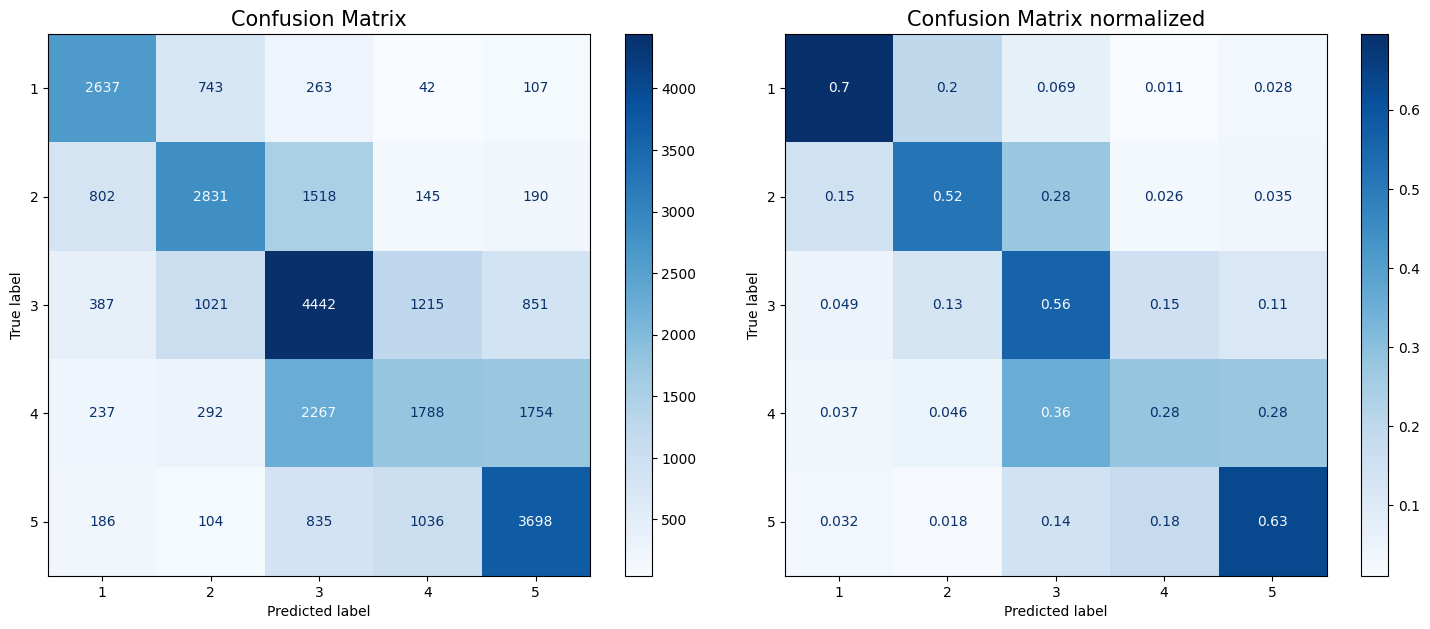

In [165]:
estimate_params_catboost(X_train_mrmr, y_train, X_valid_mrmr, y_valid)

Accuracy_train: 0.6166448342151375
Accuracy_val: 0.5232894423462965

F1_train: 0.611939415555866
Fi_val: 0.5162295319457861


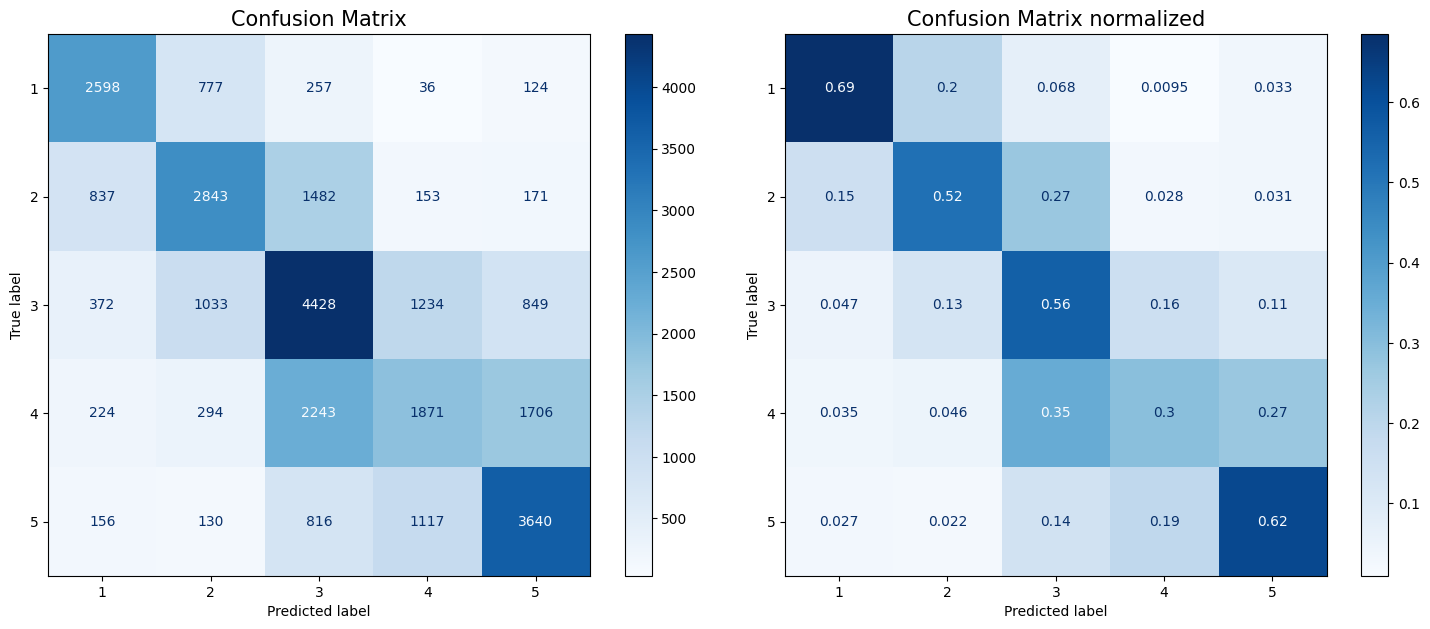

In [166]:
estimate_params_catboost(X_train_anova, y_train, X_valid_anova, y_valid) 

#### Move on with MRMR features (almos the same result but feature amount is less)

In [201]:
X_train = X_train_anova
X_valid = X_valid_anova

## Random Search

In [169]:
X_sample_tr, _, y_sample_tr, _ = train_test_split(X_train, y_train, train_size=0.1, stratify=y_train, random_state=42)
X_sample_val, _, y_sample_val, _ = train_test_split(X_valid, y_valid, train_size=0.1, stratify=y_valid, random_state=42)

In [170]:
oprimization_params = {}

### Random search

In [172]:
search_space = {
    'learning_rate': Real(0.01, 0.1, prior='uniform'),
    'l2_leaf_reg': Integer(8, 20),
    'iterations': Integer(1250, 1900),
    'depth': Integer(5, 12),
    'border_count': Integer(60, 150),
    'bagging_temperature': Real(0.7, 2, prior='uniform'),
    'loss_function': Categorical(['MultiClass'])
}

In [ ]:
bayes_search = BayesSearchCV(
    estimator=CatBoostClassifier(
        random_state=42,
        verbose=0, 
    ),
    search_spaces=search_space,
    n_iter=60,  
    cv=3,
    random_state=42,
    verbose=10,
    n_jobs=-1
)

bayes_search.fit(X_sample_tr, y_sample_tr, eval_set=[(X_sample_val, y_sample_val)], early_stopping_rounds=50)

In [174]:
bayes_search.best_params_

OrderedDict([('bagging_temperature', 1.4348427936212311),
             ('border_count', 150),
             ('depth', 5),
             ('iterations', 1900),
             ('l2_leaf_reg', 8),
             ('learning_rate', 0.05237681406372011),
             ('loss_function', 'MultiClass')])

Accuracy_train: 0.5581225225838281
Accuracy_val: 0.5201252083971284

F1_train: 0.5504399929541155
Fi_val: 0.5109074983279973


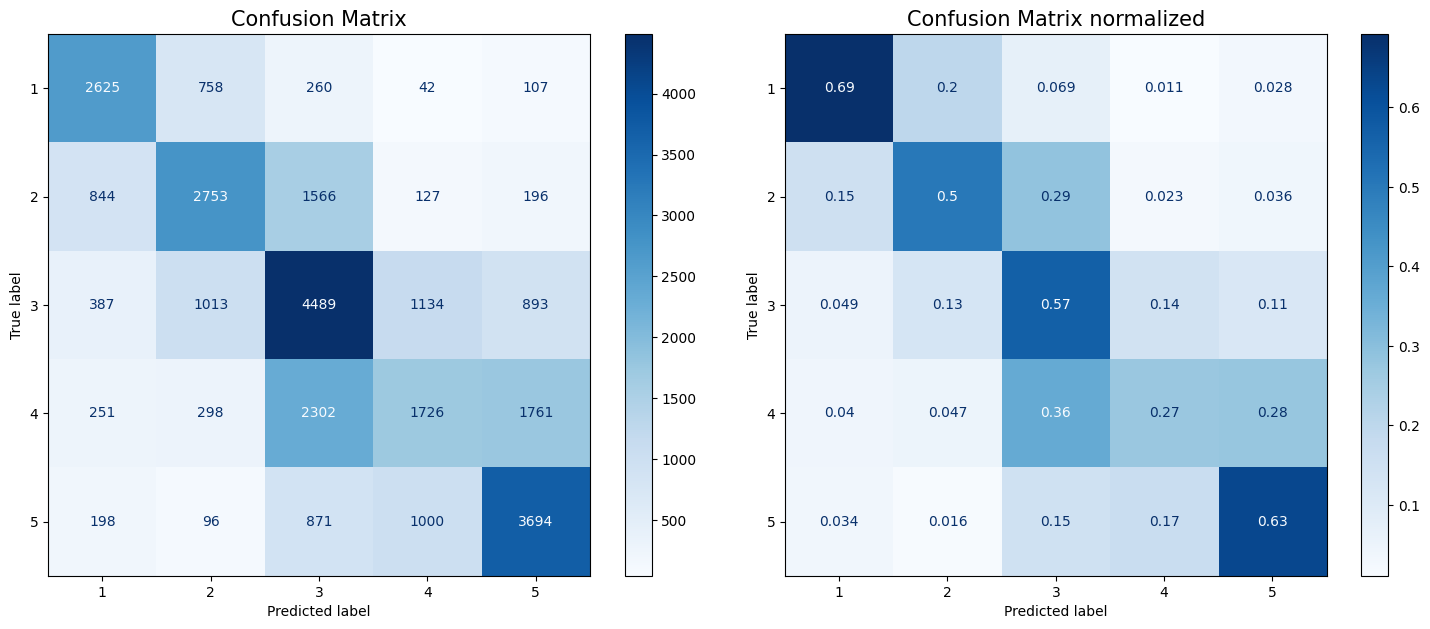

In [176]:
estimate_params_catboost(X_train,y_train, X_valid, y_valid, params= bayes_search.best_params_)

### Reduce overfitting

In [222]:
catboost_params_tuned = {
    'learning_rate': 0.03,
    'l2_leaf_reg': 5,
    'iterations': 1300,
    'depth': 4,
    'early_stopping_rounds': 50,
    'loss_function': 'MultiClass'
}

Accuracy_train: 0.5252887837906807
Accuracy_val: 0.511483107073594

F1_train: 0.5143481367662156
Fi_val: 0.5002278891021545


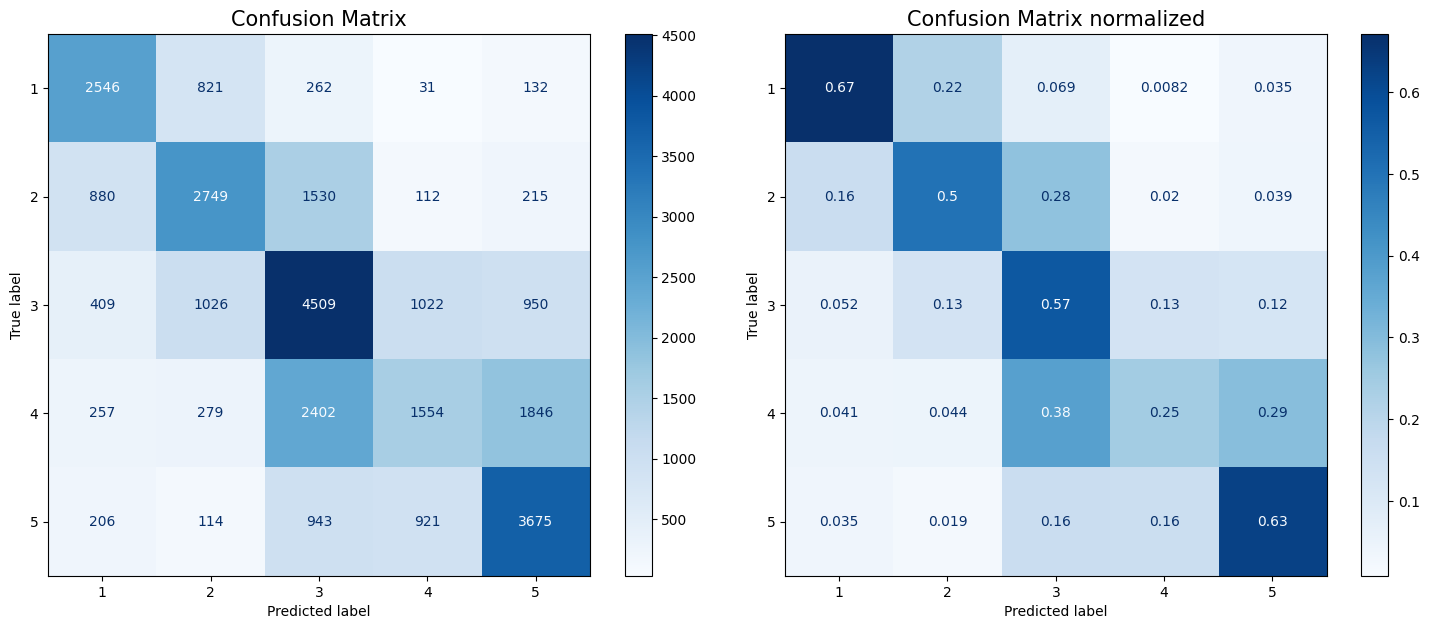

In [223]:
estimate_params_catboost(X_train, y_train, X_valid, y_valid, params = catboost_params_tuned)

## Define overfitting

### Cross validation

In [224]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

def train_model(params, kf=kf):
    list_tr_f1 = []
    list_val_f1 = []
    list_tr_acc = []
    list_val_acc = []
    
    n = 0
    for train_index, val_index in kf.split(X_train):
        n += 1
        print('Fold №', n)
        model = CatBoostClassifier(**params, random_state=42, verbose = False)
        
        X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
        
        model.fit(X_tr, y_tr)
        
        y_tr_pred = model.predict(X_tr)
        y_val_pred = model.predict(X_val)
        
        train_acc = accuracy_score(y_tr, y_tr_pred)
        val_acc = accuracy_score(y_val, y_val_pred)
        
        train_f1 = f1_score(y_tr, y_tr_pred, average='weighted')
        val_f1 = f1_score(y_val, y_val_pred, average='weighted')
        
        print('Accuracy train =', train_acc)
        print('Accuracy valid =', val_acc)
        
        print('\nF1-weighted train =', train_f1)
        print('F1-weighted valid =', val_f1)
        print('*' * 30)
        
        list_tr_f1.append(train_f1)
        list_val_f1.append(val_f1)
        
        list_tr_acc.append(train_acc)
        list_val_acc.append(val_acc)
    
    print('Total accuracy train = ', np.mean(list_tr_acc))
    print('Total accuracy valid = ', np.mean(list_val_acc))
    print('Total F1 train = ', np.mean(list_tr_f1))
    print('Total F1 valid = ', np.mean(list_val_f1))
    
    return list_tr_f1, list_val_f1, list_tr_acc, list_val_acc

list_tr_f1, list_val_f1, list_tr_acc, list_val_acc = train_model(catboost_params_tuned)

Fold № 1
Accuracy train = 0.5250129956051226
Accuracy valid = 0.5165433358850047

F1-weighted train = 0.5143102654434781
F1-weighted valid = 0.5050973323462806
******************************
Fold № 2
Accuracy train = 0.5245687821936581
Accuracy valid = 0.5173938929999149

F1-weighted train = 0.5133583780237132
F1-weighted valid = 0.5063831956740105
******************************
Fold № 3
Accuracy train = 0.5257924881386689
Accuracy valid = 0.5078257910854032

F1-weighted train = 0.5146529180220463
F1-weighted valid = 0.497131398072347
******************************
Fold № 4
Accuracy train = 0.5254333402642573
Accuracy valid = 0.5109731201088805

F1-weighted train = 0.5140415272967601
F1-weighted valid = 0.49996445719527444
******************************
Fold № 5
Accuracy train = 0.5268982855414627
Accuracy valid = 0.5

F1-weighted train = 0.5161849770823677
F1-weighted valid = 0.48709868913782883
******************************
Fold № 6
Accuracy train = 0.5270589569589627
Accuracy valid

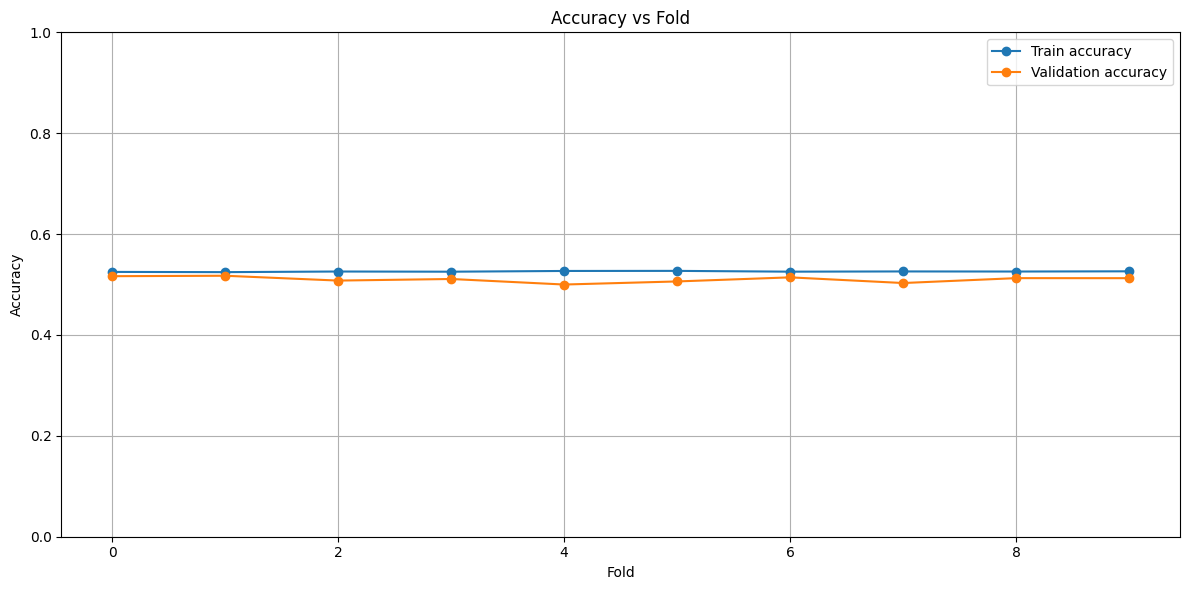

In [226]:
plt.figure(figsize=(12, 6))

plt.plot(np.arange(0, 10, 1), list_tr_acc, label='Train accuracy', marker='o')
plt.plot(np.arange(0, 10, 1), list_val_acc, label='Validation accuracy', marker='o')
plt.ylim(0, 1)
plt.grid(True)
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Fold')
plt.legend()

plt.tight_layout()
plt.show()

### Learning curve

In [228]:
catboost_params_lc =  {
    'learning_rate': 0.03,
    'l2_leaf_reg': 5,
    'iterations': 2000,
    'depth': 4,
    'early_stopping_rounds': 50,
    'loss_function': 'MultiClass'
}

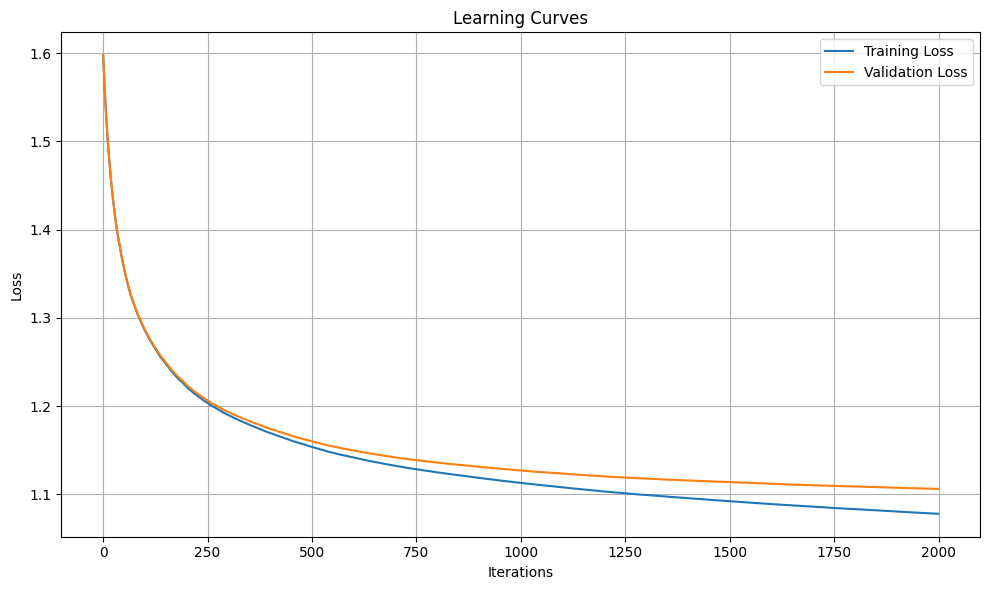

In [229]:
train_data = Pool(data=X_train, label=y_train)
valid_data = Pool(data=X_valid, label=y_valid)

model = CatBoostClassifier(**catboost_params_lc, random_state=42, verbose = False)
model.fit(train_data, eval_set=[valid_data], use_best_model=True)

evals_result = model.get_evals_result()
train_loss = evals_result['learn']['MultiClass']
valid_loss = evals_result['validation']['MultiClass']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(valid_loss, label='Validation Loss')
plt.grid(True)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Learning Curves')
plt.legend()

plt.tight_layout()
plt.show()

## Save model to pickle

In [230]:
catboost_best_model = CatBoostClassifier(**catboost_params_tuned, random_state=42, verbose = False)
catboost_best_model.fit(X_train, y_train)

In [231]:
with open("catboost_age_model_2.pkl", "wb") as file: 
    pickle.dump(catboost_best_model, file)

In [73]:
with open("catboost_age_model.pkl", "wb") as file: 
    pickle.dump(catboost_best_model, file)